## Imports

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn as nn
import random
import time
from matplotlib import pyplot as plt

## Hyperparameters and other constants

In [2]:
GAMMA = 0.99
MEMORY_SIZE = 1000000
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.001
EXPLORATION_DECAY = 0.99
NUMBER_OF_EPISODES = 2000
K_STEPS = 150
TRAIN_STEPS = 1
GOAL_SCORE = 13
ENV_PATH = 'Banana_Windows_x86_64/Banana_Windows_x86_64/Banana.exe'
MODEL_PATH = 'agent.pth'

## Auxiliar functions

Auxiliar functions used in the main program

In [3]:
# If GPU is available, use it for trainining the agent's DQN
def get_default_device():
    if torch.cuda.is_available():
        print('CUDA is available. Training on GPU.')
        return torch.device('cuda')
    else:
        print('CUDA is not available. Training on CPU.')
        return torch.device('cpu')

# Create Unity environment
def create_environment(train_mode, path_to_env):
    env = UnityEnvironment(file_name=path_to_env)
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=train_mode)[brain_name]
    number_of_observations = len(env_info.vector_observations[0])
    number_of_actions = brain.vector_action_space_size
    return env, env_info, brain_name, number_of_observations, number_of_actions

## Class ReplayMemory

Memory of transitions for experience replay.

In [1]:
class ReplayMemory:

    # Create replay memory
    def __init__(self, number_of_observations):
        self.states = np.zeros((MEMORY_SIZE, number_of_observations))
        self.states_next = np.zeros((MEMORY_SIZE, number_of_observations))
        self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
        self.rewards = np.zeros(MEMORY_SIZE)
        self.terminal_states = np.zeros(MEMORY_SIZE, dtype=bool)
        self.current_size = 0

    # Store a transition (s,a,r,s') in the replay memory
    def store_transition(self, state, action, reward, state_next, terminal_state):
        i = self.current_size
        self.states[i] = state
        self.states_next[i] = state_next
        self.actions[i] = action
        self.rewards[i] = reward
        self.terminal_states[i] = terminal_state
        self.current_size = i + 1

        if self.current_size >= MEMORY_SIZE - 1:
            self.current_size = 0

    # Generate a random sample of transitions from the replay memory
    def sample_memory(self, batch_size):
        batch = np.random.choice(self.current_size, batch_size)
        states = torch.from_numpy(self.states[batch]).float().to(device)
        states_next = torch.from_numpy(self.states_next[batch]).float().to(device)
        rewards = torch.from_numpy(self.rewards[batch]).float().to(device)
        actions = torch.from_numpy(self.actions[batch]).long().to(device)
        terminal_states = torch.from_numpy(self.terminal_states[batch]).float().to(device)
        return states, actions, rewards, states_next, terminal_states

## Class NeuralNetwork

PyTorch standard neural network

In [5]:
class NeuralNetwork(nn.Module):

    # Create neural network
    def __init__(self, number_of_observations, number_of_actions, layer_1_units=32, layer_2_units=64):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(number_of_observations, layer_1_units)
        self.layer_2 = nn.Linear(layer_1_units, layer_2_units)
        self.layer_3 = nn.Linear(layer_2_units, number_of_actions)

    # Forward pass
    def forward(self, x):
        x = torch.nn.functional.relu(self.layer_1(x))
        x = torch.nn.functional.relu(self.layer_2(x))
        x = self.layer_3(x)

        return x

## Class DQN

Reinforcement learning agent with a (double) Deep Q-Network.


In [6]:
class DQN:

    # Create DQN agent
    def __init__(self, number_of_observations, number_of_actions):
        # Initialize variables and create double neural model
        self.exploration_rate = EXPLORATION_MAX
        self.number_of_actions = number_of_actions
        self.number_of_observations = number_of_observations
        self.scores = []
        self.memory = ReplayMemory(number_of_observations)
        self.model = NeuralNetwork(number_of_observations, number_of_actions, 64, 64).to(device)
        self.target_model = NeuralNetwork(number_of_observations, number_of_actions, 64, 64).to(device)
        state_dict = self.model.state_dict()
        self.target_model.load_state_dict(state_dict)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)

    # Store a tuple (s, a, r, s') for experience replay
    def remember(self, state, action, reward, next_state, terminal_state):
        state = np.reshape(state, [1, self.number_of_observations])
        next_state = np.reshape(next_state, [1, self.number_of_observations])
        self.memory.store_transition(state, action, reward, next_state, terminal_state)

    # Generate an action for a given state using epsilon-greedy policy
    def select(self, state):
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.number_of_actions)
        else:
            state = np.reshape(state, [1, self.number_of_observations])
            self.model.eval()
            with torch.no_grad():
                q_values = self.model(torch.from_numpy(state).float().to(device)).cpu().numpy()
            self.model.train()
            return (np.argmax(q_values[0])).item()

    # Perform an action over the environment
    def step(self, action, brain_name, env):
        env_info = env.step(action)[brain_name]
        reward = env_info.rewards[0]
        next_state = env_info.vector_observations[0]
        terminal_state = env_info.local_done[0]
        return reward, next_state, terminal_state

    # Learn the value Q using a sample of examples from the replay memory. The main model predicts the best action, the target model is used to evaluate the prediction (double DQN).
    def learn(self, total_steps):
        if self.memory.current_size < BATCH_SIZE: return

        states, actions, rewards, next_states, terminal_states = self.memory.sample_memory(BATCH_SIZE)

        best_actions = self.model(states).max(1)[1]
        q_targets_next = self.target_model(next_states).gather(1, best_actions.unsqueeze(1))
        q_targets = rewards.unsqueeze(1) + (GAMMA * q_targets_next * (1 - terminal_states).unsqueeze(1))
        q_expected = self.model(states).gather(1, actions.unsqueeze(1))

        loss = nn.functional.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if total_steps % K_STEPS == 0:
            state_dict = self.model.state_dict()
            self.target_model.load_state_dict(state_dict)

    # Add the obtained score in a list to be presented later
    def add_score(self, score):
        self.scores.append(score)

    # Display the obtained scores graphically
    def display_scores_graphically(self):
        plt.plot(self.scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")

## Main program

CUDA is not available. Training on CPU.


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode   1:   average score 0.0   (exploration rate: 0.99,   transitions: 300)  score:  0.0 
Episode   2:   average score 0.0   (exploration rate: 0.98,   transitions: 600)  score:  0.0 
Episode   3:   average score 0.0   (exploration rate: 0.97,   transitions: 900)  score:  0.0 
Episode   4:   average score 0.25   (exploration rate: 0.96,   transitions: 1200)  score:  1.0 
Episode   5:   average score 0.2   (exploration rate: 0.95,   transitions: 1500)  score:  0.0 
Episode   6:   average score 0.5   (exploration rate: 0.94,   transitions: 1800)  score:  2.0 
Episode   7:   average score 0.7142857142857143   (exploration rate: 0.93,   transitions: 2100)  score:  2.0 
Episode   8:   average score 0.5   (exploration rate: 0.92,   transitions: 2400)  score:  -1.0 
Episode   9:   average score 0.4444444444444444   (exploration rate: 0.91,   transitions: 2700)  score:  0.0 
Episode  10:   average score 0.8   (exploration rate: 0.90,   transitions: 3000)  score:  4.0 
Episode  11:   averag

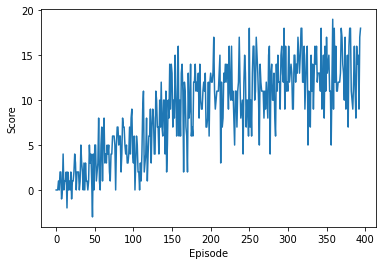

In [7]:
# Checking if GPU is available
device = get_default_device()

env, env_info, brain_name, number_of_observations, number_of_actions = create_environment(True, ENV_PATH)
agent = DQN(number_of_observations, number_of_actions)
scores = []
goal_reached = False
episode = 0
total_steps = 1
start_time = time.perf_counter()

while (episode < NUMBER_OF_EPISODES) and not goal_reached:
    episode += 1
    step = 1
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    end_episode = False
    reward_accumulated = 0
    # Decrease exploration rate
    agent.exploration_rate *= EXPLORATION_DECAY
    agent.exploration_rate = max(EXPLORATION_MIN, agent.exploration_rate)
    while not (end_episode):
        # Select an action for the current state, execute the action, retrieve env info and store transition into memory
        action = agent.select(state)
        reward, next_state, terminal_state = agent.step(action, brain_name, env)
        agent.remember(state, action, reward, next_state, terminal_state)

        # Learn using a batch of experience stored in memory
        if total_steps % TRAIN_STEPS == 0:
            agent.learn(step)

        # Detect end of episode
        if terminal_state:
            reward_accumulated += reward
            agent.add_score(reward_accumulated)
            scores.append(reward_accumulated)
            if episode < 100:
                avg_score = sum(scores) / len(scores)
            else:
                avg_score = sum(scores[-100:]) / 100
            if avg_score >= GOAL_SCORE:
                goal_reached = True
            print("Episode {0:>3}: ".format(episode),
                  " average score {0:>3} ".format(avg_score),
                  " (exploration rate: %.2f, " % agent.exploration_rate,
                  " transitions: " + str(agent.memory.current_size) + ")",
                  " score: ", reward_accumulated, '\r')

            end_episode = True
        else:
            state = next_state
            step += 1
            total_steps += 1
            reward_accumulated += reward

env.close()

# Printing some info
if goal_reached:
    print("Reached goal sucessfully.")
    torch.save(agent.model.state_dict(), MODEL_PATH)
else:
    print("Failure to reach the goal.")

print("Time:", round((time.perf_counter() - start_time) / 60), "minutes")

agent.display_scores_graphically()